In [1]:
cd /media/sharukathirimanne/OS/Users/Sharuka Thirimanne/Desktop/FYP-ML-IDS

/media/sharukathirimanne/OS/Users/Sharuka Thirimanne/Desktop/FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import Model, layers
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# Pipeline Saving
from pickle import dump
from io import StringIO
import joblib
from keras.models import model_from_json
import json

import datetime


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

# ML Model Training

In [5]:
def train_preprocess():
    df_train = pd.read_csv('Datasets/csv_result-KDDTrain+.csv')
    df_train.drop(['id'], axis = 'columns' , inplace = True)
    
    col_list = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
                'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
                'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','class']
    
    df_train = df_train[col_list]
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    num_features = len(df_train.columns) - 1
    print('Number of features before feature selection :',num_features)
    print('Original dataset duplicates :',df_train.duplicated().sum())

    num_features = len(df_train.columns) - 1
    print('Number of features after feature selection :',num_features)
    print('Duplicates after feature selection :',df_train.duplicated().sum())
    for col in ['protocol_type','flag','service']:
        df_train[col] = df_train[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_train['service'].value_counts().index[30:]
    df_train['service'] = df_train['service'].cat.add_categories([label1])
    df_train['service'] = df_train['service'].replace(others1, label1)

    df_train['service'].replace({'time':'Other_service','urp_i':'Other_service',
                                 'csnet_ns':'Other_service','supdup':'Other_service',
                                 'discard':'Other_service','http_443':'Other_service'}, inplace = True)
    
    print('Duplicates after category reduction :',df_train.duplicated().sum())
    df_train['class'] = df_train['class'].map( {'normal':0, 'anomaly':1} )
    df_train.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_train.duplicated().sum())
    df_train.reset_index(drop=True,inplace=True)
    
    return df_train
df_train = train_preprocess()

Number of features before feature selection : 28
Original dataset duplicates : 27
Number of features after feature selection : 28
Duplicates after feature selection : 27
Duplicates after category reduction : 1486
Duplicates after duplicate drop : 0


In [6]:
print(df_train['protocol_type'].value_counts())
print('======================================')
print(df_train['service'].value_counts())
print('======================================')
print(df_train['flag'].value_counts())

tcp     101212
udp      14993
icmp      8282
Name: protocol_type, dtype: int64
http             40332
private          21853
Other_service    12075
domain_u          9043
smtp              7313
ftp_data          6848
eco_i             4582
other             4359
ecr_i             3072
telnet            2353
finger            1767
ftp               1754
auth               955
Z39_50             862
uucp               780
courier            734
bgp                710
whois              693
uucp_path          689
iso_tsap           687
imap4              647
nnsp               630
vmnet              617
domain             569
ctf                563
Name: service, dtype: int64
SF        74918
S0        33653
REJ       11058
RSTR       2389
RSTO       1527
S1          365
SH          252
S2          127
RSTOS0      103
S3           49
OTH          46
Name: flag, dtype: int64


In [7]:
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [8]:
df_train.shape

(124487, 29)

In [9]:
limit1 = df_train.shape[1]-1
    
X_train = df_train.iloc[:,0:limit1] # train set features
y_train = df_train.iloc[:,limit1]

In [10]:
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [11]:
categorical_cols = ['protocol_type','flag','service']
std_cols = ['duration','src_bytes','dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count','serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate','same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate',
            'dst_host_rerror_rate','dst_host_srv_rerror_rate']

In [12]:
X_train.shape

(124487, 28)

In [13]:
ohe = OneHotEncoder()
std_scaler = StandardScaler()

columnTransformer = make_column_transformer(
    ( ohe, categorical_cols),
    (std_scaler,std_cols), 
    remainder='passthrough')

X_train = columnTransformer.fit_transform(X_train)

In [14]:
X_train.shape

(124487, 64)

In [15]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [16]:
#Neural Network Model
model = Sequential()
model.add(Dense(256, input_dim=64, activation='relu', kernel_initializer='glorot_uniform', 
                bias_initializer='zeros'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x=X_train, y=y_train, epochs=50, validation_split=0.3, 
                    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50
2724/2724 [==============================] - 18s 3ms/step - loss: 0.0678 - accuracy: 0.9650 - precision: 0.9631 - recall: 0.9659 - auc: 0.9908 - val_loss: 0.0355 - val_accuracy: 0.9839 - val_precision: 0.9861 - val_recall: 0.9788 - val_auc: 0.9981
Epoch 2/50
2724/2724 [==============================] - 7s 3ms/step - loss: 0.0323 - accuracy: 0.9853 - precision: 0.9868 - recall: 0.9811 - auc: 0.9984 - val_loss: 0.0240 - val_accuracy: 0.9869 - val_precision: 0.9886 - val_recall: 0.9827 - val_auc: 0.9987
Epoch 3/50
2724/2724 [==============================] - 8s 3ms/step - loss: 0.0246 - accuracy: 0.9874 - precision: 0.9894 - recall: 0.9832 - auc: 0.9988 - val_loss: 0.0249 - val_accuracy: 0.9882 - val_precision: 0.9903 - val_recall: 0.9840 - val_auc: 0.9990
Epoch 4/50
2724/2724 [==============================] - 9s 3ms/step - loss: 0.0220 - accuracy: 0.9886 - precision: 0.9908 - recall: 0.9842 - auc: 0.9990 - val_loss: 0.0211 - val_accuracy: 0.9892 - val_precision: 0.9911 - val_

Epoch 33/50
2724/2724 [==============================] - 8s 3ms/step - loss: 0.0091 - accuracy: 0.9945 - precision: 0.9956 - recall: 0.9923 - auc: 0.9995 - val_loss: 0.0610 - val_accuracy: 0.9945 - val_precision: 0.9956 - val_recall: 0.9924 - val_auc: 0.9996
Epoch 34/50
2724/2724 [==============================] - 9s 3ms/step - loss: 0.0086 - accuracy: 0.9945 - precision: 0.9957 - recall: 0.9924 - auc: 0.9995 - val_loss: 0.0454 - val_accuracy: 0.9945 - val_precision: 0.9957 - val_recall: 0.9924 - val_auc: 0.9996
Epoch 35/50
2724/2724 [==============================] - 8s 3ms/step - loss: 0.0088 - accuracy: 0.9946 - precision: 0.9957 - recall: 0.9924 - auc: 0.9995 - val_loss: 0.0381 - val_accuracy: 0.9946 - val_precision: 0.9957 - val_recall: 0.9925 - val_auc: 0.9996
Epoch 36/50
2724/2724 [==============================] - 8s 3ms/step - loss: 0.0139 - accuracy: 0.9946 - precision: 0.9957 - recall: 0.9925 - auc: 0.9995 - val_loss: 0.0370 - val_accuracy: 0.9946 - val_precision: 0.9958 - v

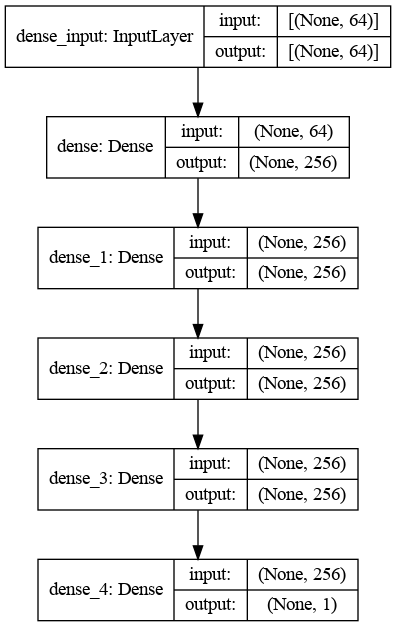

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

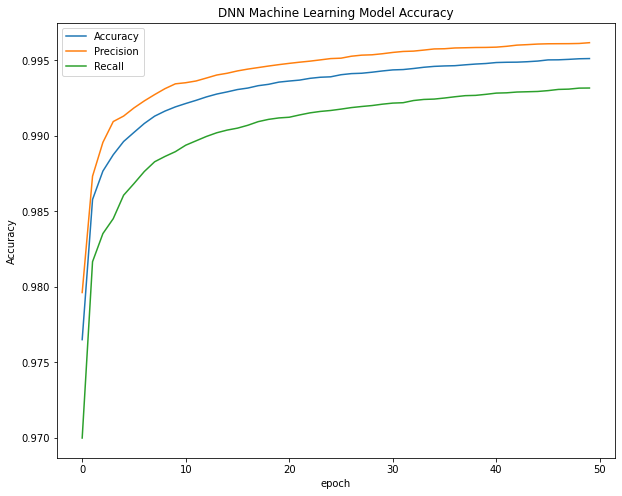

In [18]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('DNN Machine Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Precision','Recall'], loc='upper left')
plt.show()

In [20]:
%tensorboard --logdir logs/fit

# Testing 

In [21]:
def test_preprocess():
    df_test = pd.read_csv('Datasets/csv_result-KDDTest+.csv')
    df_test.drop(['id'], axis = 'columns' , inplace = True)
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    col_list = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
                'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
                'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','class']
    
    df_test = df_test[col_list]
        
    for col in ['protocol_type','flag','service']:
        df_test[col] = df_test[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_test['service'].value_counts().index[30:]
    # apply new category label
    df_test['service'] = df_test['service'].cat.add_categories([label1])
    df_test['service'] = df_test['service'].replace(others1, label1)

    print('Duplicates after category reduction :',df_test.duplicated().sum())
    df_test['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                                'link':'Other_service','name':'Other_service','echo':'Other_service',
                                'netbios_ns':'Other_service'}, inplace = True)
    
    df_test['class'] = df_test['class'].map( {'normal':0, 'anomaly':1} )
    df_test.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_test.duplicated().sum())
    
    return df_test
df_test = test_preprocess()

Duplicates after category reduction : 44
Duplicates after duplicate drop : 0


In [22]:
print(df_test['protocol_type'].value_counts())
print('======================================')
print(df_test['service'].value_counts())
print('======================================')
print(df_test['flag'].value_counts())

tcp     18828
udp      2621
icmp     1043
Name: protocol_type, dtype: int64
http             7849
private          4774
Other_service    2040
telnet           1626
smtp              934
domain_u          894
other             835
ftp_data          833
ecr_i             752
ftp               692
imap4             306
eco_i             262
finger            136
auth               67
domain             51
uucp               50
iso_tsap           48
bgp                46
uucp_path          46
Z39_50             45
vmnet              43
nnsp               42
ctf                41
whois              40
courier            40
Name: service, dtype: int64
SF        14853
REJ        3839
S0         1996
RSTO        771
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
Name: flag, dtype: int64


In [23]:
df_test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [24]:
len(df_test.columns)

29

In [25]:
limit2 = df_test.shape[1]-1
    
X_test = df_test.iloc[:,0:limit2] # train set features
Y_test = df_test.iloc[:,limit2]

In [26]:
X_test = columnTransformer.transform(X_test)

In [27]:
X_test.shape

(22492, 64)

In [28]:
test_predictions = model.predict(X_test)
test_predictions

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0564365e-05],
       ...,
       [1.3810694e-03],
       [0.0000000e+00],
       [4.8350441e-01]], dtype=float32)

In [29]:
print(np.unique(test_predictions))

[0.0000000e+00 1.2017428e-38 1.3916125e-38 ... 9.9999982e-01 9.9999988e-01
 1.0000000e+00]


In [30]:
test_predictions[5]

array([1.8527738e-15], dtype=float32)

In [31]:
rounded_test_predictions = []

for i, value in enumerate(test_predictions):
    if value > 0.5:
        rounded_test_predictions.append(1)
    else:
        rounded_test_predictions.append(0)
                

True Negatives  : 0.9440
False Positives : 0.0560
False Negatives : 0.3641
True Positives  : 0.6359


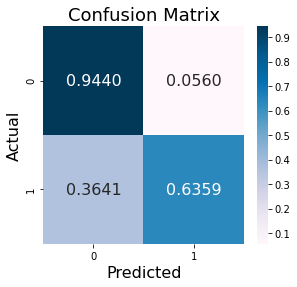

In [32]:
def plot_cm(labels, predictions, title = 'Confusion Matrix'):
    cm = confusion_matrix(labels, predictions, normalize= 'true')
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, cmap= 'PuBu', annot=True, fmt='.4f', annot_kws=    {'size':16})
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title(title, fontsize=18)

    print('True Negatives  : {:.4f}'.format(cm[0][0]))
    print('False Positives : {:.4f}'.format(cm[0][1]))
    print('False Negatives : {:.4f}'.format(cm[1][0]))
    print('True Positives  : {:.4f}'.format(cm[1][1]))
    
plot_cm(Y_test,rounded_test_predictions)

In [33]:
print("Test set accuracy  : {:.4f}".format(accuracy_score(Y_test, rounded_test_predictions)))
print("Test set precision : {:.4f}".format(precision_score(Y_test, rounded_test_predictions)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, rounded_test_predictions)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, rounded_test_predictions)))

Test set accuracy  : 0.7689
Test set precision : 0.9373
Test set recall    : 0.6359
Test set F1-score  : 0.7577


<ipython-input-35-129bfb7c9ca4>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


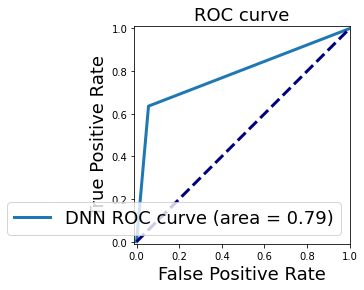

In [35]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(Y_test, rounded_test_predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='DNN ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## Saving ML Model and OneHotEncoder/StandardScaler

In [36]:
# saving model
json_model = model.to_json()
open('DNN_Realtime_Model.json', 'w').write(json_model)
# saving weights
model.save_weights('DNN_model_weights.h5', overwrite=True)

In [37]:
joblib.dump(columnTransformer,"DNN_Realtime_ColumnTransformer")

['DNN_Realtime_ColumnTransformer']